In [1]:
import endomill
import yaml


In [2]:
parameter_packs = [
    {
        "MILL_TREATMENT_NAME": treatment,
        "MILL_REPLICATE": replicate,
    }
    for treatment in ["bag", "ring", "allopatry"]
    for replicate in range(10)
]


for i, pp in enumerate(parameter_packs):
    with open(f"species-inference-parameterization-{i}.yaml", "w") as file:
        yaml.safe_dump(pp, file)
# endomill.instantiate_over(parameter_packs=parameter_packs)


# Papermill Parameters


In [3]:
MILL_TREATMENT_NAME: str
MILL_REPLICATE: int


In [4]:
# Parameters
MILL_REPLICATE = 5
MILL_TREATMENT_NAME = "ring"


# Global Setup


In [5]:
import copy
import math
import itertools as it
import typing
import random

import alifedata_phyloinformatics_convert as apc
from Bio import Phylo as BioPhylo
from deap import algorithms as deap_algorithms
from deap import base as deap_base
from deap import creator as deap_creator
from deap import tools as deap_tools

from hstrat import hstrat
from iterpop import iterpop as ip
from keyname import keyname as kn
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
import sympy
from teeplot import teeplot as tp
from tqdm import tqdm

import pylib


In [6]:
random.seed(MILL_REPLICATE)


In [7]:
nbm.print_metadata()


context: local
hostname: thinkpad
interpreter: 3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]
nbcellexec: null
nbname: None
nbpath: None
revision: null
session: c1951ccb-978a-4093-88ee-4024a5af2506
timestamp: 2023-05-23T19:45:40Z00:00




IPython==7.31.1
keyname==0.5.2
yaml==6.0
Bio==1.79
alifedata_phyloinformatics_convert==0.13.0
deap==1.3
endomill==0.1.3
hstrat==1.6.1
iterpop==0.4.1
matplotlib==3.6.2
nbmetalog==0.2.6
numpy==1.23.5
pandas==1.5.2
scipy==1.10.1
seaborn==0.12.1
sympy==1.9
teeplot==0.5.0
re==2.2.1
debugpy==1.6.6
logging==0.5.1.2
psutil==5.9.0
zmq==22.3.0
json==2.0.9
ipykernel==6.7.0


# Parameters


In [8]:
HSTRAT_DIFFERENTIA_WIDTH = 64
NGEN = 200
NPOP = 100
NTOURN = 2


# Setup


In [9]:
deap_creator.create("FitnessMax", deap_base.Fitness, weights=(1.0,))
deap_creator.create("Individual", list, fitness=deap_creator.FitnessMax)

toolbox = deap_base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register(
    "individual",
    deap_tools.initRepeat,
    deap_creator.Individual,
    toolbox.attr_bool,
    n=100,
)
toolbox.register("population", deap_tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    return (sum(individual),)


toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", deap_tools.cxTwoPoint)
toolbox.register("mutate", deap_tools.mutFlipBit, indpb=0.05)
toolbox.register("select", deap_tools.selTournament, tournsize=NTOURN)

# Decorate the variation operators
history = deap_tools.History()
toolbox.decorate("mate", history.decorator)

toolbox.decorate("mate", pylib.deap.hstrat_mate_decorator)


# Evolve


In [10]:
# Create the population and populate the history
population = toolbox.population(n=NPOP)

species_ancestor = hstrat.HereditaryStratigraphicColumn(
    stratum_retention_policy=hstrat.perfect_resolution_algo.Policy(),
    stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
)
gene_ancestor = hstrat.HereditaryStratigraphicColumn(
    stratum_retention_policy=hstrat.perfect_resolution_algo.Policy(),
    stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
    initial_stratum_annotation=0,
)
for member in population:
    member.species_annotation = species_ancestor.CloneDescendant()
    member.gene_annotation = gene_ancestor.CloneDescendant(0)

history.update(population)

# Do the evolution, the decorators will take care of updating the
# history
if MILL_TREATMENT_NAME == "bag":
    for _gen in range(NGEN):
        offspring = deap_algorithms.varAnd(
            population,
            toolbox,
            cxpb=1.0,
            mutpb=1.0,
        )
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=NPOP)
        population = [copy.deepcopy(ind) for ind in population]

elif MILL_TREATMENT_NAME == "ring":
    NUM_ISLANDS = 10
    NUM_MIGRATIONS = 1
    slice_size = len(population) // NUM_ISLANDS
    for gen in tqdm(range(NGEN)):
        for slice_ in pylib.util.iter_slices(len(population), slice_size):
            subpopulation = population[slice_]
            offspring = deap_algorithms.varAnd(
                subpopulation, toolbox, cxpb=1.0, mutpb=1.0
            )
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            subpopulation = toolbox.select(offspring, k=len(subpopulation))
            population[slice_] = [copy.deepcopy(ind) for ind in subpopulation]

        for m in range(NUM_MIGRATIONS):
            displacement = random.randrange(slice_size, 2 * slice_size)
            a = random.randrange(len(population))
            b = (a + displacement) % len(population)
            population[a], population[b] = population[b], population[a]

    from_subpopulations = []
    for i in range(0, len(population), slice_size):
        subpopulation = population[i : i + slice_size]
        from_subpopulations.extend(subpopulation)
    population = from_subpopulations

elif MILL_TREATMENT_NAME == "allopatry":
    # sympatry
    for gen in tqdm(range(NGEN // 2)):
        offspring = deap_algorithms.varAnd(
            population, toolbox, cxpb=1.0, mutpb=1.0
        )
        fits = toolbox.map(toolbox.evaluate, offspring)

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))
        population = [copy.deepcopy(ind) for ind in population]

    # two-island allopatry
    slice_size = NPOP // 2
    from_subpopulations = []
    for i in range(0, len(population), slice_size):
        subpopulation = population[i : i + slice_size]
        for gen in tqdm(range(NGEN // 4)):
            offspring = deap_algorithms.varAnd(
                subpopulation, toolbox, cxpb=1.0, mutpb=1.0
            )
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            subpopulation = toolbox.select(offspring, k=len(subpopulation))
            subpopulation = [copy.deepcopy(ind) for ind in subpopulation]

        from_subpopulations.extend(subpopulation)
    population = from_subpopulations

    # three-island allopatry: left island
    slice_size = NPOP // 2
    from_subpopulations = []
    for i in range(0, len(population) // 2, slice_size):
        subpopulation = population[i : i + slice_size]
        for gen in tqdm(range(NGEN // 4)):
            offspring = deap_algorithms.varAnd(
                subpopulation, toolbox, cxpb=1.0, mutpb=1.0
            )
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            subpopulation = toolbox.select(offspring, k=len(subpopulation))
            subpopulation = [copy.deepcopy(ind) for ind in subpopulation]

        from_subpopulations.extend(subpopulation)

    # three-island allopatry: right five islands
    slice_size = NPOP // 10
    for i in range(len(population) // 2, len(population), slice_size):
        subpopulation = population[i : i + slice_size]
        for gen in tqdm(range(NGEN // 4)):
            offspring = deap_algorithms.varAnd(
                subpopulation, toolbox, cxpb=1.0, mutpb=1.0
            )
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            subpopulation = toolbox.select(offspring, k=len(subpopulation))
            subpopulation = [copy.deepcopy(ind) for ind in subpopulation]

        from_subpopulations.extend(subpopulation)

    population = from_subpopulations

else:
    assert False, MILL_TREATMENT_NAME

# ensure all extant organisms registered with phylogeny tracker
for x in population:
    history.update([x])


  0%|                                                                                                                                                                 | 0/200 [00:00<?, ?it/s]

  0%|▊                                                                                                                                                        | 1/200 [00:00<02:31,  1.31it/s]

  1%|█▌                                                                                                                                                       | 2/200 [00:01<02:06,  1.57it/s]

  2%|██▎                                                                                                                                                      | 3/200 [00:01<02:02,  1.61it/s]

  2%|███                                                                                                                                                      | 4/200 [00:02<02:00,  1.63it/s]

  2%|███▊                                                                                                                                                     | 5/200 [00:03<02:13,  1.46it/s]

  3%|████▌                                                                                                                                                    | 6/200 [00:03<02:11,  1.47it/s]

  4%|█████▎                                                                                                                                                   | 7/200 [00:04<02:11,  1.47it/s]

  4%|██████                                                                                                                                                   | 8/200 [00:05<02:12,  1.45it/s]

  4%|██████▉                                                                                                                                                  | 9/200 [00:06<02:14,  1.42it/s]

  5%|███████▌                                                                                                                                                | 10/200 [00:07<02:33,  1.23it/s]

  6%|████████▎                                                                                                                                               | 11/200 [00:07<02:29,  1.27it/s]

  6%|█████████                                                                                                                                               | 12/200 [00:08<02:26,  1.28it/s]

  6%|█████████▉                                                                                                                                              | 13/200 [00:09<02:30,  1.25it/s]

  7%|██████████▋                                                                                                                                             | 14/200 [00:10<02:46,  1.11it/s]

  8%|███████████▍                                                                                                                                            | 15/200 [00:11<02:36,  1.18it/s]

  8%|████████████▏                                                                                                                                           | 16/200 [00:12<02:26,  1.25it/s]

  8%|████████████▉                                                                                                                                           | 17/200 [00:13<02:36,  1.17it/s]

  9%|█████████████▋                                                                                                                                          | 18/200 [00:14<03:01,  1.00it/s]

 10%|██████████████▍                                                                                                                                         | 19/200 [00:15<03:02,  1.01s/it]

 10%|███████████████▏                                                                                                                                        | 20/200 [00:16<03:04,  1.03s/it]

 10%|███████████████▉                                                                                                                                        | 21/200 [00:17<03:07,  1.05s/it]

 11%|████████████████▋                                                                                                                                       | 22/200 [00:18<03:09,  1.07s/it]

 12%|█████████████████▍                                                                                                                                      | 23/200 [00:19<03:15,  1.10s/it]

 12%|██████████████████▏                                                                                                                                     | 24/200 [00:20<03:14,  1.11s/it]

 12%|███████████████████                                                                                                                                     | 25/200 [00:21<02:59,  1.03s/it]

 13%|███████████████████▊                                                                                                                                    | 26/200 [00:23<03:24,  1.17s/it]

 14%|████████████████████▌                                                                                                                                   | 27/200 [00:24<03:23,  1.18s/it]

 14%|█████████████████████▎                                                                                                                                  | 28/200 [00:25<03:14,  1.13s/it]

 14%|██████████████████████                                                                                                                                  | 29/200 [00:26<03:22,  1.19s/it]

 15%|██████████████████████▊                                                                                                                                 | 30/200 [00:28<03:44,  1.32s/it]

 16%|███████████████████████▌                                                                                                                                | 31/200 [00:29<03:41,  1.31s/it]

 16%|████████████████████████▎                                                                                                                               | 32/200 [00:31<03:38,  1.30s/it]

 16%|█████████████████████████                                                                                                                               | 33/200 [00:32<03:39,  1.31s/it]

 17%|█████████████████████████▊                                                                                                                              | 34/200 [00:34<03:59,  1.45s/it]

 18%|██████████████████████████▌                                                                                                                             | 35/200 [00:35<03:55,  1.42s/it]

 18%|███████████████████████████▎                                                                                                                            | 36/200 [00:36<03:54,  1.43s/it]

 18%|████████████████████████████                                                                                                                            | 37/200 [00:38<03:56,  1.45s/it]

 19%|████████████████████████████▉                                                                                                                           | 38/200 [00:39<03:57,  1.46s/it]

 20%|█████████████████████████████▋                                                                                                                          | 39/200 [00:41<04:16,  1.59s/it]

 20%|██████████████████████████████▍                                                                                                                         | 40/200 [00:43<04:11,  1.57s/it]

 20%|███████████████████████████████▏                                                                                                                        | 41/200 [00:44<04:03,  1.53s/it]

 21%|███████████████████████████████▉                                                                                                                        | 42/200 [00:46<03:56,  1.50s/it]

 22%|████████████████████████████████▋                                                                                                                       | 43/200 [00:48<04:24,  1.69s/it]

 22%|█████████████████████████████████▍                                                                                                                      | 44/200 [00:49<03:59,  1.53s/it]

 22%|██████████████████████████████████▏                                                                                                                     | 45/200 [00:51<03:59,  1.54s/it]

 23%|██████████████████████████████████▉                                                                                                                     | 46/200 [00:52<03:37,  1.41s/it]

 24%|███████████████████████████████████▋                                                                                                                    | 47/200 [00:53<03:50,  1.51s/it]

 24%|████████████████████████████████████▍                                                                                                                   | 48/200 [00:56<04:23,  1.73s/it]

 24%|█████████████████████████████████████▏                                                                                                                  | 49/200 [00:57<04:05,  1.63s/it]

 25%|██████████████████████████████████████                                                                                                                  | 50/200 [00:58<03:53,  1.56s/it]

 26%|██████████████████████████████████████▊                                                                                                                 | 51/200 [01:00<03:57,  1.60s/it]

 26%|███████████████████████████████████████▌                                                                                                                | 52/200 [01:02<04:28,  1.81s/it]

 26%|████████████████████████████████████████▎                                                                                                               | 53/200 [01:04<04:24,  1.80s/it]

 27%|█████████████████████████████████████████                                                                                                               | 54/200 [01:06<04:09,  1.71s/it]

 28%|█████████████████████████████████████████▊                                                                                                              | 55/200 [01:07<03:53,  1.61s/it]

 28%|██████████████████████████████████████████▌                                                                                                             | 56/200 [01:09<04:08,  1.73s/it]

 28%|███████████████████████████████████████████▎                                                                                                            | 57/200 [01:12<04:53,  2.05s/it]

 29%|████████████████████████████████████████████                                                                                                            | 58/200 [01:14<04:47,  2.02s/it]

 30%|████████████████████████████████████████████▊                                                                                                           | 59/200 [01:16<04:53,  2.08s/it]

 30%|█████████████████████████████████████████████▌                                                                                                          | 60/200 [01:18<04:54,  2.10s/it]

 30%|██████████████████████████████████████████████▎                                                                                                         | 61/200 [01:20<04:43,  2.04s/it]

 31%|███████████████████████████████████████████████                                                                                                         | 62/200 [01:22<04:43,  2.05s/it]

 32%|███████████████████████████████████████████████▉                                                                                                        | 63/200 [01:24<04:25,  1.94s/it]

 32%|████████████████████████████████████████████████▋                                                                                                       | 64/200 [01:26<04:10,  1.84s/it]

 32%|█████████████████████████████████████████████████▍                                                                                                      | 65/200 [01:27<04:02,  1.80s/it]

 33%|██████████████████████████████████████████████████▏                                                                                                     | 66/200 [01:30<04:20,  1.95s/it]

 34%|██████████████████████████████████████████████████▉                                                                                                     | 67/200 [01:32<04:32,  2.05s/it]

 34%|███████████████████████████████████████████████████▋                                                                                                    | 68/200 [01:34<04:41,  2.13s/it]

 34%|████████████████████████████████████████████████████▍                                                                                                   | 69/200 [01:37<04:49,  2.21s/it]

 35%|█████████████████████████████████████████████████████▏                                                                                                  | 70/200 [01:38<04:29,  2.07s/it]

 36%|█████████████████████████████████████████████████████▉                                                                                                  | 71/200 [01:41<04:43,  2.20s/it]

 36%|██████████████████████████████████████████████████████▋                                                                                                 | 72/200 [01:44<05:22,  2.52s/it]

 36%|███████████████████████████████████████████████████████▍                                                                                                | 73/200 [01:47<05:19,  2.52s/it]

 37%|████████████████████████████████████████████████████████▏                                                                                               | 74/200 [01:48<04:44,  2.26s/it]

 38%|█████████████████████████████████████████████████████████                                                                                               | 75/200 [01:51<04:56,  2.37s/it]

 38%|█████████████████████████████████████████████████████████▊                                                                                              | 76/200 [01:53<05:02,  2.44s/it]

 38%|██████████████████████████████████████████████████████████▌                                                                                             | 77/200 [01:57<05:41,  2.78s/it]

 39%|███████████████████████████████████████████████████████████▎                                                                                            | 78/200 [02:00<05:32,  2.72s/it]

 40%|████████████████████████████████████████████████████████████                                                                                            | 79/200 [02:02<05:24,  2.68s/it]

 40%|████████████████████████████████████████████████████████████▊                                                                                           | 80/200 [02:05<05:18,  2.66s/it]

 40%|█████████████████████████████████████████████████████████████▌                                                                                          | 81/200 [02:07<04:56,  2.49s/it]

 41%|██████████████████████████████████████████████████████████████▎                                                                                         | 82/200 [02:10<05:06,  2.60s/it]

 42%|███████████████████████████████████████████████████████████████                                                                                         | 83/200 [02:12<04:57,  2.54s/it]

 42%|███████████████████████████████████████████████████████████████▊                                                                                        | 84/200 [02:14<04:42,  2.44s/it]

 42%|████████████████████████████████████████████████████████████████▌                                                                                       | 85/200 [02:16<04:09,  2.17s/it]

 43%|█████████████████████████████████████████████████████████████████▎                                                                                      | 86/200 [02:18<03:53,  2.05s/it]

 44%|██████████████████████████████████████████████████████████████████                                                                                      | 87/200 [02:20<03:52,  2.06s/it]

 44%|██████████████████████████████████████████████████████████████████▉                                                                                     | 88/200 [02:22<04:10,  2.23s/it]

 44%|███████████████████████████████████████████████████████████████████▋                                                                                    | 89/200 [02:25<04:04,  2.20s/it]

 45%|████████████████████████████████████████████████████████████████████▍                                                                                   | 90/200 [02:27<03:58,  2.17s/it]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                                  | 91/200 [02:29<03:56,  2.17s/it]

 46%|█████████████████████████████████████████████████████████████████████▉                                                                                  | 92/200 [02:31<03:54,  2.18s/it]

 46%|██████████████████████████████████████████████████████████████████████▋                                                                                 | 93/200 [02:34<04:23,  2.47s/it]

 47%|███████████████████████████████████████████████████████████████████████▍                                                                                | 94/200 [02:36<04:16,  2.42s/it]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                               | 95/200 [02:39<04:11,  2.40s/it]

 48%|████████████████████████████████████████████████████████████████████████▉                                                                               | 96/200 [02:41<04:08,  2.39s/it]

 48%|█████████████████████████████████████████████████████████████████████████▋                                                                              | 97/200 [02:44<04:05,  2.38s/it]

 49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 98/200 [02:46<04:01,  2.37s/it]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                            | 99/200 [02:50<04:41,  2.78s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 100/200 [02:53<04:43,  2.83s/it]

 50%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 101/200 [02:56<04:57,  3.00s/it]

 51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 102/200 [02:59<05:05,  3.12s/it]

 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 103/200 [03:02<05:01,  3.11s/it]

 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 104/200 [03:06<05:06,  3.19s/it]

 52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 105/200 [03:11<05:49,  3.67s/it]

 53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 106/200 [03:14<05:42,  3.64s/it]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 107/200 [03:18<05:37,  3.63s/it]

 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 108/200 [03:21<05:33,  3.62s/it]

 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 109/200 [03:25<05:29,  3.62s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 110/200 [03:30<06:01,  4.02s/it]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 111/200 [03:34<05:48,  3.92s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 112/200 [03:37<05:40,  3.86s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 113/200 [03:41<05:29,  3.79s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 114/200 [03:45<05:25,  3.78s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                | 115/200 [03:49<05:21,  3.78s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 116/200 [03:54<05:54,  4.22s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 117/200 [03:58<05:41,  4.12s/it]

 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 118/200 [04:02<05:32,  4.05s/it]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 119/200 [04:05<05:25,  4.02s/it]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 120/200 [04:09<05:19,  4.00s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 121/200 [04:12<04:42,  3.57s/it]

 61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 122/200 [04:15<04:16,  3.28s/it]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 123/200 [04:19<04:27,  3.47s/it]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 124/200 [04:21<03:54,  3.08s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 125/200 [04:23<03:33,  2.85s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 126/200 [04:25<03:18,  2.69s/it]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 127/200 [04:28<03:12,  2.64s/it]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 128/200 [04:32<03:35,  3.00s/it]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 129/200 [04:36<03:53,  3.29s/it]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 130/200 [04:39<03:42,  3.18s/it]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 131/200 [04:43<04:00,  3.49s/it]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 132/200 [04:47<04:11,  3.70s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 133/200 [04:51<04:18,  3.85s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 134/200 [04:55<04:22,  3.98s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 135/200 [05:00<04:24,  4.08s/it]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 136/200 [05:04<04:27,  4.18s/it]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 137/200 [05:09<04:28,  4.27s/it]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 138/200 [05:11<03:56,  3.82s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 139/200 [05:14<03:32,  3.48s/it]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 140/200 [05:17<03:11,  3.20s/it]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 141/200 [05:19<02:59,  3.04s/it]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 142/200 [05:23<03:14,  3.36s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 143/200 [05:26<02:58,  3.12s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 144/200 [05:29<02:46,  2.98s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 145/200 [05:33<03:10,  3.46s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 146/200 [05:38<03:25,  3.80s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 147/200 [05:42<03:34,  4.04s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 148/200 [05:46<03:22,  3.90s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 149/200 [05:50<03:19,  3.91s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 150/200 [05:53<03:05,  3.71s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 151/200 [05:57<02:59,  3.66s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 152/200 [06:00<02:54,  3.64s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 153/200 [06:04<02:49,  3.61s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 154/200 [06:07<02:45,  3.61s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 155/200 [06:11<02:38,  3.52s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 156/200 [06:14<02:36,  3.55s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 157/200 [06:20<02:54,  4.06s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 158/200 [06:23<02:45,  3.94s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 159/200 [06:27<02:39,  3.88s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 160/200 [06:31<02:34,  3.85s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 161/200 [06:36<02:45,  4.23s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 162/200 [06:41<02:45,  4.35s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 163/200 [06:44<02:35,  4.20s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 164/200 [06:50<02:41,  4.49s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 165/200 [06:53<02:24,  4.12s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 166/200 [06:56<02:10,  3.85s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 167/200 [06:59<02:02,  3.70s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 168/200 [07:02<01:52,  3.50s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 169/200 [07:06<01:45,  3.40s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 170/200 [07:09<01:43,  3.44s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 171/200 [07:12<01:38,  3.41s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 172/200 [07:20<02:07,  4.56s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 173/200 [07:25<02:11,  4.86s/it]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 174/200 [07:31<02:11,  5.06s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 175/200 [07:36<02:09,  5.20s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 176/200 [07:42<02:07,  5.30s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 177/200 [07:46<01:52,  4.88s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 178/200 [07:51<01:51,  5.08s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 179/200 [07:55<01:35,  4.57s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 180/200 [08:03<01:53,  5.69s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 181/200 [08:09<01:48,  5.68s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 182/200 [08:14<01:42,  5.69s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 183/200 [08:20<01:36,  5.70s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 184/200 [08:26<01:31,  5.70s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 185/200 [08:32<01:25,  5.70s/it]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 186/200 [08:37<01:20,  5.71s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 187/200 [08:43<01:14,  5.74s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 188/200 [08:52<01:20,  6.68s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 189/200 [08:58<01:10,  6.43s/it]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 190/200 [09:04<01:02,  6.28s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 191/200 [09:10<00:55,  6.20s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 192/200 [09:14<00:45,  5.72s/it]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 193/200 [09:19<00:37,  5.30s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 194/200 [09:23<00:30,  5.00s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 195/200 [09:27<00:24,  4.81s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 196/200 [09:32<00:18,  4.68s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 197/200 [09:39<00:16,  5.40s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 198/200 [09:43<00:10,  5.12s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 199/200 [09:48<00:04,  4.94s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [09:52<00:00,  4.81s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [09:52<00:00,  2.96s/it]

# Reconstruction


In [11]:
extant_nodes = [individual.history_index for individual in population]
reconstructed_df = hstrat.build_tree(
    [individual.species_annotation for individual in population],
    version_pin=hstrat.__version__,
    force_common_ancestry=True,
    taxon_labels=map(str, extant_nodes),
)
reconstructed_df["name"] = reconstructed_df["taxon_label"]
reconstructed_df.to_csv(
    kn.pack(
        {
            "a": "phylogeny",
            "notebook": "species-inference",
            "replicate": str(MILL_REPLICATE),
            "treatment": MILL_TREATMENT_NAME,
            "type": "reconstruction",
            "ext": ".csv",
        }
    )
)
reconstructed_df


,id,ancestor_list,origin_time,taxon_label,ancestor_id,name
0,0,[none],0.0,Root,0,Root
156,156,[0],155.0,Inner+r=155+d=PQcddPVVR0P+uid=CUOcdG2N3S78rweL...,0,Inner+r=155+d=PQcddPVVR0P+uid=CUOcdG2N3S78rweL...
167,167,[156],161.0,Inner+r=161+d=PzSEbU6t9-i+uid=C6qtZREieTL94YJ0...,156,Inner+r=161+d=PzSEbU6t9-i+uid=C6qtZREieTL94YJ0...
179,179,[167],165.0,Inner+r=165+d=PkbP0bVg9GH+uid=pYGWY8jVit7XSje6...,167,Inner+r=165+d=PkbP0bVg9GH+uid=pYGWY8jVit7XSje6...
185,185,[167],167.0,Inner+r=167+d=PfsyGlDnYWA+uid=t-BC5LFmYWapNqCL...,167,Inner+r=167+d=PfsyGlDnYWA+uid=t-BC5LFmYWapNqCL...
...,...,...,...,...,...,...
796,796,[599],201.0,20163,599,20163
797,797,[599],201.0,20162,599,20162
798,798,[600],201.0,20164,600,20164
799,799,[600],201.0,20170,600,20170


teeplots/./notebook=species-inference+replicate=5+treatment=ring+type=reconstruction+viz=draw-biopython-tree+ext=.pdf


teeplots/./notebook=species-inference+replicate=5+treatment=ring+type=reconstruction+viz=draw-biopython-tree+ext=.png


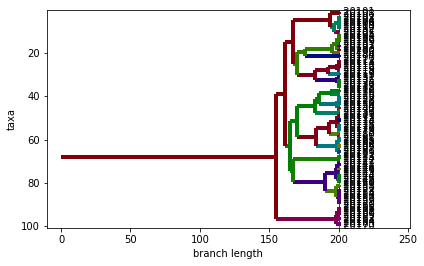

In [12]:
reconstructed_tree = apc.alife_dataframe_to_biopython_tree(
    reconstructed_df, setup_branch_lengths=True
)
BioPhylo.write(
    reconstructed_tree,
    kn.pack(
        {
            "a": "phylogeny",
            "notebook": "species-inference",
            "replicate": str(MILL_REPLICATE),
            "treatment": MILL_TREATMENT_NAME,
            "type": "reconstruction",
            "ext": ".nwk",
        }
    ),
    'newick',
)
tp.tee(
    pylib.tree.draw_biopython_tree,
    reconstructed_tree,
    teeplot_outattrs={
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "reconstruction",
    },
)


teeplots/./drop_overlapping_labels=true+notebook=species-inference+replicate=5+treatment=ring+type=reconstruction+viz=draw-biopython-tree+ext=.pdf


teeplots/./drop_overlapping_labels=true+notebook=species-inference+replicate=5+treatment=ring+type=reconstruction+viz=draw-biopython-tree+ext=.png


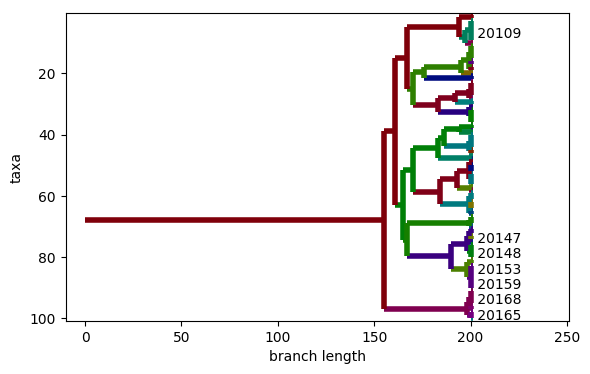

In [13]:
reconstructed_tree = apc.alife_dataframe_to_biopython_tree(
    reconstructed_df, setup_branch_lengths=True
)
tp.tee(
    pylib.tree.draw_biopython_tree,
    reconstructed_tree,
    drop_overlapping_labels=True,
    teeplot_outattrs={
        "drop_overlapping_labels": "true",
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "reconstruction",
    },
)


teeplots/./max_leaves=20+notebook=species-inference+replicate=5+treatment=ring+type=reconstruction+viz=draw-biopython-tree+ext=.pdf


teeplots/./max_leaves=20+notebook=species-inference+replicate=5+treatment=ring+type=reconstruction+viz=draw-biopython-tree+ext=.png


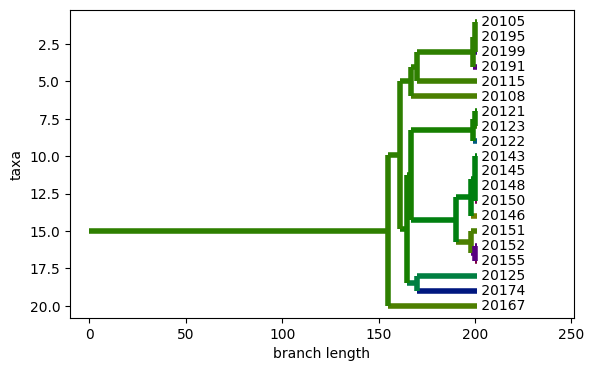

In [14]:
reconstructed_tree = apc.alife_dataframe_to_biopython_tree(
    reconstructed_df, setup_branch_lengths=True
)
tp.tee(
    pylib.tree.draw_biopython_tree,
    reconstructed_tree,
    max_leaves=20,
    teeplot_outattrs={
        "max_leaves": "20",
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "reconstruction",
    },
)


# Actual Pedigree


In [15]:
distilled_tree = pylib.deap.history_to_tree_upgma(history, extant_nodes)
BioPhylo.write(
    distilled_tree,
    kn.pack(
        {
            "a": "phylogeny",
            "notebook": "species-inference",
            "replicate": str(MILL_REPLICATE),
            "treatment": MILL_TREATMENT_NAME,
            "type": "distilled-pedigree",
            "ext": ".nwk",
        }
    ),
    'newick',
)


1

teeplots/./notebook=species-inference+replicate=5+treatment=ring+type=distilled-reference+viz=draw-biopython-tree+ext=.pdf


teeplots/./notebook=species-inference+replicate=5+treatment=ring+type=distilled-reference+viz=draw-biopython-tree+ext=.png


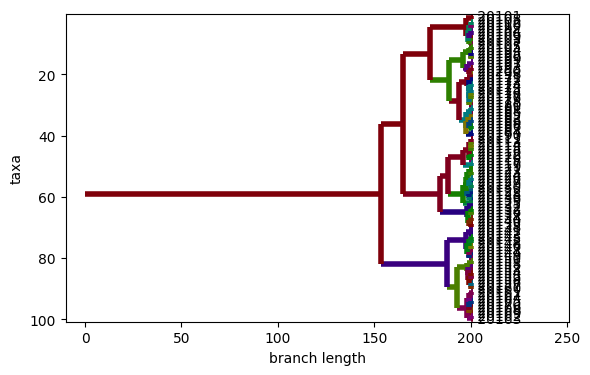

In [16]:
tp.tee(
    pylib.tree.draw_biopython_tree,
    distilled_tree,
    teeplot_outattrs={
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "distilled-reference",
    },
)


teeplots/./max_leaves=20+notebook=species-inference+replicate=5+treatment=ring+type=distilled-reference+viz=draw-biopython-tree+ext=.pdf


teeplots/./max_leaves=20+notebook=species-inference+replicate=5+treatment=ring+type=distilled-reference+viz=draw-biopython-tree+ext=.png


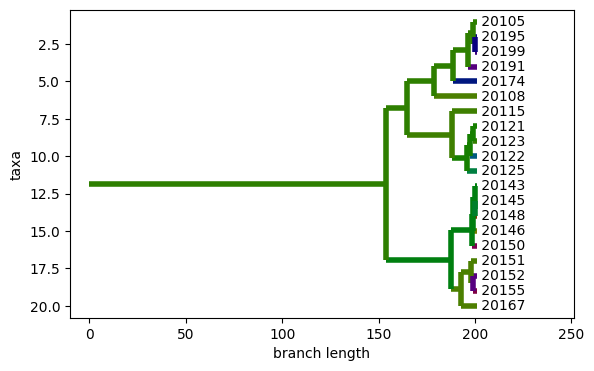

In [17]:
tp.tee(
    pylib.tree.draw_biopython_tree,
    distilled_tree,
    max_leaves=20,
    teeplot_outattrs={
        "max_leaves": "20",
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "distilled-reference",
    },
)


teeplots/./drop_overlapping_labels=true+notebook=species-inference+replicate=5+treatment=ring+type=distilled-reference+viz=draw-biopython-tree+ext=.pdf


teeplots/./drop_overlapping_labels=true+notebook=species-inference+replicate=5+treatment=ring+type=distilled-reference+viz=draw-biopython-tree+ext=.png


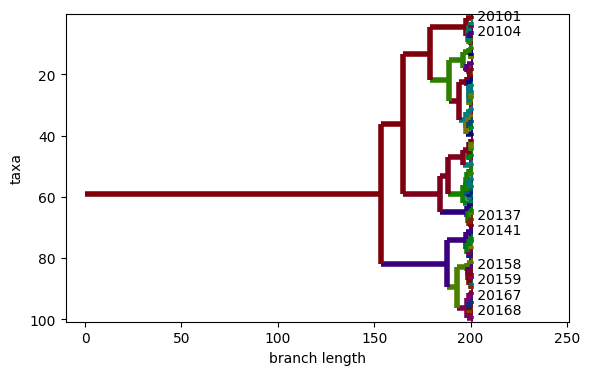

In [18]:
tp.tee(
    pylib.tree.draw_biopython_tree,
    distilled_tree,
    drop_overlapping_labels=True,
    teeplot_outattrs={
        "drop_overlapping_labels": "true",
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "distilled-reference",
    },
)


In [19]:
distilled_tree = pylib.deap.history_to_tree_upgma(
    history, extant_nodes, correct_origin_times=False
)
BioPhylo.write(
    distilled_tree,
    kn.pack(
        {
            "a": "phylogeny",
            "notebook": "species-inference",
            "replicate": str(MILL_REPLICATE),
            "treatment": MILL_TREATMENT_NAME,
            "type": "distilled-pedigree-uncorrected",
            "ext": ".nwk",
        }
    ),
    'newick',
)

quartet_dist = pylib.tree.polymorphic_quartet_distance(
    reconstructed_tree, distilled_tree
)
quartet_dist


0.38780916677823896

In [20]:
records = [
    {
        "replicate": MILL_REPLICATE,
        "treatment": MILL_TREATMENT_NAME,
        "quartet distance": quartet_dist,
    }
]
outdf = pd.DataFrame.from_records(records)
outdf.to_csv(
    kn.pack(
        {
            "a": "reconstruction-accuracy",
            "notebook": "species-inference",
            "replicate": MILL_REPLICATE,
            "treatment": MILL_TREATMENT_NAME,
            "ext": ".csv",
        }
    )
)
outdf


,replicate,treatment,quartet distance
0,5,ring,0.387809
